<a href="https://colab.research.google.com/github/alexlautw9527/for_notebook/blob/main/%E6%94%BF%E5%BA%9C%E5%9C%B0%E7%90%86%E8%B3%87%E8%A8%8A%E6%95%B4%E7%90%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import re
import time
import os
from datetime import datetime
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from string import Template
import urllib
import json
import pickle


from pprint import pprint
import sys

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
from sklearn.decomposition import PCA, SparsePCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [144]:
pd.set_option('display.max_rows', 500)


In [28]:
## 經濟地理資訊平台API抓的資料

with open('/content/drive/MyDrive/03_RESOURCE/GIS/gis_open_api.pickle', 'rb') as f:
    api_data = pickle.load(f)

In [29]:

# 分行爬蟲資訊

## 各分行地址與基本資訊
brn_df = pd.read_csv('/content/drive/MyDrive/03_RESOURCE/GIS/taishin_brn.csv').drop_duplicates()

## 分行地址與點位
brn_xy_df = pd.read_csv('/content/drive/MyDrive/03_RESOURCE/GIS/brn_xy_df.csv')

## 合併並去掉重複
brn_df = brn_df.merge(brn_xy_df,how='left' ,on = 'addr').copy()
brn_df = brn_df.drop_duplicates()

## 作為主表
brn_code_df = brn_df[['brn', 'addr', 'lon', 'lat']]

## 整理經濟三級發布區
brn_code3_df = pd.DataFrame(
    [(x,api_data[x]['code3_data']['ADMIV']['CODE3']) for x in list(api_data.keys()) if x !='南崁分行'],
    columns = ['brn','eco_code3']
)
brn_code3_df = pd.concat([brn_code3_df, pd.DataFrame([['南崁分行','A6800005028']], columns=['brn','eco_code3'])])
brn_code3_df = brn_code3_df.reset_index(drop=True)

## 整理統計二級發布區
brn_code2_df = pd.read_csv('/content/drive/MyDrive/03_RESOURCE/GIS/分行統計區代碼對照.csv', encoding='CP950')
brn_code2_df = brn_code2_df[['ID','縣市', '鄉鎮市區', '村里', '二級發布區', '一級發布區', '最小統計區']].rename(
    {
      'ID': 'brn',
      '縣市':'city',
      '鄉鎮市區':'town',
      '村里':'village',
      '二級發布區':'code_2',
      '一級發布區':'code_1',
      '最小統計區':'code_min'
    },
    axis=1
)

# 整併
brn_code_df = brn_code_df.merge(brn_code2_df, how='left', on=['brn'])
brn_code_df = brn_code_df.merge(brn_code3_df, how='left', on=['brn'])

# 資料清理
## 處理異體字跟鄉鎮市區層級更名

brn_code_df['town'] = brn_code_df['town'].replace('員林鎮', '員林市')
brn_code_df.loc[brn_code_df['town']=='新店區','village'] = brn_code_df.loc[brn_code_df['town']=='新店區','village'].replace('五?里', '五峰里')


In [189]:
pd.read_csv('/content/drive/MyDrive/03_RESOURCE/GIS/109年11月行政區電信信令人口統計資料_鄉鎮市區.csv', encoding='CP950')

,COUNTY_ID,COUNTY,TOWN_ID,TOWN,NIGHT_WORK,DAY_WORK(7:00~13:00),DAY_WORK(13:00~19:00),DAY_WORK,NIGHT_WEEKEND,DAY_WEEKEND(7:00~13:00),DAY_WEEKEND(13:00~19:00),DAY_WEEKEND,MORNING_WORK,MIDDAY_WORK,AFTERNOON_WORK,EVENING_WORK,MORNING_WEEKEND,MIDDAY_WEEKEND,AFTERNOON_WEEKEND,EVENING_WEEKEND,INFO_TIME
0,縣市代碼,縣市名稱,鄉鎮市區代碼,鄉鎮市區名稱,平日夜間停留人數,平日上午活動人數,平日下午活動人數,平日日間活動人數,假日夜間停留人數,假日上午活動人數,假日下午活動人數,假日日間活動人數,平日早晨旅次,平日中午旅次,平日午後旅次,平日晚上旅次,假日早晨旅次,假日中午旅次,假日午後旅次,假日晚上旅次,資料時間
1,65000,新北市,65000010,板橋區,577007,468604,459821,461811,574620,553665,547852,552865,1370756.45,1199378.12,1217279.46,1417770.61,1181447.57,1447237.98,1452579.49,1427165.52,109Y11M
2,65000,新北市,65000020,三重區,426580,353762,336820,343466,424259,402368,379533,395318,1047368.37,873343.72,880980.15,1000009.8,887589.65,1004799.36,975547.52,939548.09,109Y11M
3,65000,新北市,65000030,中和區,470287,414013,398795,408358,466276,439917,417541,433865,1142144.94,995924.74,991048.66,1074345.45,966434.32,1062291.77,1036495.62,972990.59,109Y11M
4,65000,新北市,65000040,永和區,232342,169268,157426,161573,230134,215493,199485,210496,513518.18,415321.92,414020.3,495365.41,461549.08,526167.13,495412.61,485350.57,109Y11M
5,65000,新北市,65000050,新莊區,446481,381702,374563,377239,443620,426704,419179,426607,1093803.05,925342.9,929744.79,1077273.18,925176.4,1086124.76,1056036.59,1001453.5,109Y11M
6,65000,新北市,65000060,新店區,346150,316147,303348,309344,343603,332771,315198,328460,780546.29,694581.09,693588.67,718829.75,650811.86,746315.92,729628.39,657317.14,109Y11M
7,65000,新北市,65000070,樹林區,202270,190785,187977,189656,202721,195384,190928,195311,489739.83,420652.53,426735.44,451024.04,397929.01,447903.69,441277.45,430214.61,109Y11M
8,65000,新北市,65000080,鶯歌區,90900,81480,80218,80939,91143,87876,86757,87625,207558.07,171225.54,179422.75,188227.64,175110.32,203134.32,207767.99,192814.35,109Y11M
9,65000,新北市,65000090,三峽區,120827,105834,104205,104524,121910,123685,120884,122589,258058.78,234151.71,238437.49,244033.42,238756.25,304760.89,301355.44,253190.16,109Y11M


In [30]:
# 公司行號工廠資訊

poi_num_df = []
for brn in list(api_data.keys()):
    df = pd.DataFrame([list(api_data[brn]['around_num'].values())],columns=['factory_num','bu_num', 'cmp_num', 'stk_num'])
    poi_num_df.append(df)
poi_num_df = pd.concat(poi_num_df)
poi_num_df['brn'] = list(api_data.keys())

In [31]:
## openstreetmap資料
import pickle
with open('/content/drive/MyDrive/03_RESOURCE/GIS/brn_poi.pickle', 'rb') as f:
  poi = pickle.load(f)

In [32]:
## 人口資料

pop_ratio = pd.read_csv('/content/drive/MyDrive/03_RESOURCE/GIS/台灣二級統計區人口指標.csv')
pop_data = pd.read_csv('/content/drive/MyDrive/03_RESOURCE/GIS/台灣二級統計區人口資料.csv')

pop_ratio = pop_ratio.rename({'CODE2':'code_2'},axis=1)
pop_data = pop_data.rename({'CODE2':'code_2'},axis=1)


In [33]:
## 年收入資料 
## 資料年度107年 單位千元
sal_df = pd.read_csv('https://www.fia.gov.tw/WEB/fia/ias/ias106/106_165-9.csv')

In [34]:
%%capture
## 電子發票
## 資料年度107年 

"""
e_inv_amt_df = pd.read_csv('https://egis.moea.gov.tw/EGIS_FILE/EGP_SD/107_B2C_SalesAmount.csv')
e_inv_store_cnt_df = pd.read_csv('https://egis.moea.gov.tw/EGIS_FILE/EGP_SD/107_B2C_StoreCount.csv')
e_inv_cnt_df = pd.read_csv('https://egis.moea.gov.tw/EGIS_FILE/EGP_SD/107_B2C_InvoiceCount.csv')

## 有點怪怪的

e_inv_amt_df = e_inv_amt_df.replace(-99,np.nan)
e_inv_amt_df['EINV_AMT'] = e_inv_cnt_df.loc[:,'1月':'12月'].sum(axis=1,skipna=False)

e_inv_store_cnt_df = e_inv_store_cnt_df.replace(-99,np.nan)
e_inv_store_cnt_df['EINV_BU_CNT'] = e_inv_store_cnt_df.loc[:,'1月':'12月'].sum(axis=1,skipna=False)

e_inv_cnt_df = e_inv_cnt_df.replace(-99,np.nan)
e_inv_cnt_df['EINV_CNT'] = e_inv_cnt_df.loc[:,'1月':'12月'].sum(axis=1,skipna=False)
"""

In [131]:
## 政府製作的消費熱度

e_inv_ratio = pd.read_csv('https://sip.einvoice.nat.gov.tw/ods-main/ODS308E/download/691C0280-CEFB-488F-9E71-6AA4F39A41CD/1/1124193D-09F5-4711-AB9A-01848E3B88E4/0/?fileType=csv')

In [151]:
def whitespace_remover(dataframe):
    # iterating over the columns
    for i in dataframe.columns:        
        # checking datatype of each columns
        if dataframe[i].dtype == 'object':       
            # applying strip function on column
            dataframe[i] = dataframe[i].str.replace('\s+', '', regex=True)
        else:              
            # if condn. is False then it will do nothing.
            pass

In [152]:
e_inv_ratio = e_inv_ratio[e_inv_ratio['年度']==2020][['縣市','鄉鎮市區', '村里','主行業別', '消費熱度計算來源', '張數指標', '銷售額指標']]
e_inv_ratio.eval('綜合指標 = (張數指標+銷售額指標)/2', inplace=True)

## groupby mean計算不同計算來源

e_inv_ratio = e_inv_ratio.groupby(['縣市', '鄉鎮市區', '村里', '主行業別'])[['綜合指標']]\
.agg('mean')\
.reset_index(level=[0,1,2,3])

e_inv_ratio = e_inv_ratio.pivot_table(index=['縣市', '鄉鎮市區', '村里'], columns = ['主行業別'], values = ['綜合指標']).fillna(0)
e_inv_ratio.columns = ['_'.join(col) for col in e_inv_ratio.columns.values]
e_inv_ratio = e_inv_ratio.reset_index()


In [153]:
e_inv_ratio.columns = ['city','town','village','hotel_ind', 'retail_ind', 'ctring_ind']

In [163]:
e_inv_ratio['village'] = e_inv_ratio['village'].replace('?賢里','群賢里')
#e_inv_ratio.query('village.str.contains("賢")', engine='python')

電子發票消費熱度指標

https://data.gov.tw/dataset/36843

https://sip.einvoice.nat.gov.tw/ods-main/ODS308E/download/691C0280-CEFB-488F-9E71-6AA4F39A41CD/1/1124193D-09F5-4711-AB9A-01848E3B88E4/0/?fileType=csv

finlab實價登錄爬蟲
https://www.finlab.tw/real-estate-analasys-histograms/

## 開始整併

In [164]:
'''
性比例	戶量	人口密度  扶養比	扶幼比	扶老比	老化指數
'''
pop_ratio.head(3)

,city,code_2,M_F_RAT,P_H_CNT,P_DEN,DEPENDENCY_RAT,A0A14_A15A65_RAT,A65UP_A15A64_RAT,A65_A0A14_RAT,INFO_TIME
0,南投縣,A0801-01,91.86,2.91,3512.41,52.33,27.77,24.56,88.45,109Y12M
1,南投縣,A0801-02,80.50,2.23,1568.15,94.48,20.04,74.44,371.56,109Y12M
2,南投縣,A0801-03,115.34,2.73,384.38,40.75,13.08,27.66,211.48,109Y12M


In [165]:
sal_dict={
  '縣市':'city',
  '鄉鎮市區':'town',
  '村里':'village',
  '平均數':'sal_mean',
  '中位數':'sal_med'
}

sal_df.columns = ['city', 'town', 'village', 'tax_unit_cnt', 'all_amt', 'sal_mean', 'sal_med', 'Q1', 'Q3', 'std', 's']
sal_df['village'] = sal_df['village'].replace('羣賢里','群賢里')

In [166]:
## 人口指標
brn_gis_df = brn_code_df.merge(pop_ratio[['code_2','P_DEN','A65UP_A15A64_RAT']], how='left', left_on='code_2', right_on='code_2')

## 年收
brn_gis_df = brn_gis_df.merge(sal_df[['city', 'town', 'village','sal_mean', 'sal_med']], how='left', on=['town','city','village'])

## 消費熱度
brn_gis_df = brn_gis_df.merge(e_inv_ratio, how='left', on=['town','city','village'])


## 公司行號工廠
brn_gis_df = brn_gis_df.merge(poi_num_df, how='left', on='brn')



In [167]:
feat_list = [
    'P_DEN', 'A65UP_A15A64_RAT',
    'sal_mean', 'sal_med', 
    'factory_num', 'bu_num', 'cmp_num', 'stk_num', 
    'hotel_ind', 'retail_ind', 'ctring_ind'
]

In [ ]:
arr = brn_gis_df[feat_list]
brn_gis_df[['brn','city','town','village']+feat_list]


In [173]:
brn_gis_df[brn_gis_df.isnull().any(axis=1)]

,brn,addr,lon,lat,city,town,village,code_2,code_1,code_min,eco_code3,P_DEN,A65UP_A15A64_RAT,sal_mean,sal_med,hotel_ind,retail_ind,ctring_ind,factory_num,bu_num,cmp_num,stk_num


## 集群

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


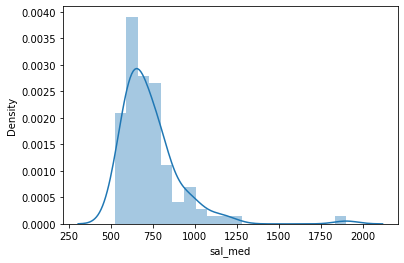

In [174]:
import seaborn as sns
sns.distplot(arr['sal_med'])

In [175]:
from sklearn.preprocessing import MinMaxScaler
arr = MinMaxScaler().fit_transform(arr)

In [183]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

clstr_labels = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(arr).labels_
brn_gis_df['cluster'] = clstr_labels

In [184]:
pca_comp2_arr = PCA(2).fit_transform(arr)

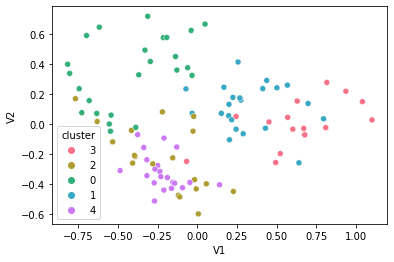

In [185]:
df_PCA = pd.DataFrame(pca_comp2_arr, columns = ['V1', "V2"])
df_PCA['cluster'] = clstr_labels.astype(int).astype(str)

PCA_plot = sns.scatterplot(
    x='V1', y = 'V2', 
    data=df_PCA,
    palette=sns.color_palette('husl',5),
    hue = 'cluster'
)

In [186]:
brn_gis_df[['brn','city','town','cluster']].sort_values('cluster')

,brn,city,town,cluster
90,竹北分行,新竹縣,竹北市,0
35,彰化分行,彰化縣,彰化市,0
36,五甲分行,高雄市,鳳山區,0
92,八德分行,桃園市,八德區,0
87,北大分行,新竹市,北區,0
26,三重分行,新北市,三重區,0
93,員林分行,彰化縣,員林市,0
23,七賢分行,高雄市,新興區,0
21,花蓮分行,花蓮縣,花蓮市,0
20,豐原分行,臺中市,豐原區,0
